### TransformerEncoder layers for transforming the ECG to the R-peaks encoding

In [1]:
import os
import numpy as np
import matplotlib.pyplot as plt
import torch
from torch import nn
import torch.optim as optim
from torch.utils.data import Dataset, DataLoader
from tqdm import tqdm

In [2]:
torch.cuda.empty_cache()

In [3]:
DATASET_PATH = "./dataset"

In [4]:
x_train = np.expand_dims(np.load(os.path.join(DATASET_PATH, "x_train.npy")), -1)[:5000]
y_train = np.expand_dims(np.load(os.path.join(DATASET_PATH, "y_train.npy")), -1)[:5000]

x_test = np.expand_dims(np.load(os.path.join(DATASET_PATH, "x_test.npy")), -1)[:500]
y_test = np.expand_dims(np.load(os.path.join(DATASET_PATH, "y_test.npy")), -1)[:500]

x_val = np.expand_dims(np.load(os.path.join(DATASET_PATH, "x_val.npy")), -1)[:1000]
y_val = np.expand_dims(np.load(os.path.join(DATASET_PATH, "y_val.npy")), -1)[:1000]

In [5]:
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
print('Training will be performed with:',device)

Training will be performed with: cuda:0


In [6]:
class ECGDataset(Dataset):
  def __init__(self, data, labels):
    super(ECGDataset, self).__init__()
    self.data = data
    self.labels = labels

  def __len__(self):
    return self.data.shape[0]
  
  def __getitem__(self, idx):
    sample = torch.tensor(self.data[idx], dtype=torch.float32)
    label = torch.tensor(self.labels[idx], dtype=torch.float32)
    return sample, label

In [7]:
class WeightedBCELoss(nn.Module):
  def __init__(self, negative_weight=None, positive_weight=None):
    super(WeightedBCELoss, self).__init__()
    self.w_n = negative_weight
    self.w_p = positive_weight

  def forward(self, prediction, ground_truth, epsilon=1e-7):
    if self.w_n is None or self.w_p is None:
        # Calculate weights for the current batch
        pos_weight = (ground_truth == 1).float().sum()
        neg_weight = (ground_truth == 0).float().sum()
        total = pos_weight + neg_weight
        self.w_p = neg_weight / total
        self.w_n = pos_weight / total
    
    loss_pos = -1 * self.w_p * (ground_truth * torch.log(prediction + epsilon)).mean()
    loss_neg = -1 * self.w_n * ((1 - ground_truth) * torch.log(1 - prediction + epsilon)).mean()
  
    return loss_pos + loss_neg


In [94]:
class SimpleTransformerModel(nn.Module):
    def __init__(self, input_dim, seq_length, num_layers, num_heads, dim_feedforward, dropout):
        super(SimpleTransformerModel, self).__init__()
        
        self.input_dim = input_dim
        self.seq_length = seq_length

        self.embedding_layer = nn.Sequential(
            nn.Conv1d(1, 16, padding=1, kernel_size=3),
            nn.ReLU(),
            nn.Conv1d(16, 32, padding=1, kernel_size=3),
            nn.ReLU(),
            nn.Conv1d(32, input_dim, padding=1, kernel_size=3),
            nn.ReLU(),
        )
        
        self.encoder_layer = nn.TransformerEncoderLayer(d_model=input_dim, nhead=num_heads, dim_feedforward=dim_feedforward, dropout=dropout)
        self.transformer_encoder = nn.TransformerEncoder(self.encoder_layer, num_layers=num_layers)
        self.dense = nn.Linear(input_dim, 1)
        self.sigmoid = nn.Sigmoid()

        self.criterion = WeightedBCELoss(negative_weight=0.2, positive_weight=0.8)
        self.optim = optim.Adam(self.parameters(), lr=1e-3)

    def forward(self, x):
        # x shape: [batch_size, seq_length, 1]
        x = x.permute(0, 2, 1)  # Reshape to [batch_size, in_channels (1), seq_length]
        embedded = self.embedding_layer(x)  # Shape: [batch_size, input_dim, seq_length]
        embedded = embedded.permute(2, 0, 1) # Shape: [seq_length, batch_size, input_dim]

        transformed = self.transformer_encoder(embedded)  # Shape: [seq_length, batch_size, input_dim]
        transformed = transformed.permute(1, 0, 2)  # Reshape to [batch_size, seq_length, input_dim]

        output = self.dense(transformed)  # Shape: [batch_size, seq_length, 1]
        
        return self.sigmoid(output)
    
    def train_model(self, x_train, y_train, epochs, batch_size=1, x_val=None, y_val=None,):
        self.batch_size = batch_size
        dataset = ECGDataset(x_train, y_train)
        train_loader = DataLoader(dataset, batch_size, shuffle=True)

        if x_val is not None:
            validation_dataset = ECGDataset(x_val, y_val)
            validation_loader = DataLoader(validation_dataset, batch_size=batch_size, shuffle=True)

        for epoch in range(epochs):
            running_loss = 0.0
            logs = ""

            self.train()
            for i, (x, y) in tqdm(enumerate(train_loader), total=len(train_loader)):
                x, y = x.to(device), y.to(device)

                self.optim.zero_grad()
                outputs = self(x)

                loss = self.criterion(outputs, y)
                running_loss += loss.item()

                loss.backward()
                self.optim.step()

            logs += f"Epoch [{epoch+1}/{epochs}] Loss: {running_loss / len(train_loader)}]"
            if x_val is not None:
                vloss = self.validate(validation_loader)
                logs += f" Validation Loss: {vloss}"

            print(logs)

    def validate(self, validation_loader):
        running_vloss = 0.0
        self.eval()

        with torch.no_grad():
            for i, (x_val, y_val) in enumerate(validation_loader):
                x, y = x_val.to(device), y_val.to(device)
                outputs = self(x)

                loss = self.criterion(outputs, y)
                running_vloss += loss.item()

        return running_vloss / len(validation_loader)

    def test_model(self, x_test, y_test):

        test_dataset = ECGDataset(x_test, y_test)
        test_loader = DataLoader(test_dataset, batch_size=1, shuffle=True)

        running_loss = 0.0
        self.eval()
        with torch.no_grad():
            for i, (x_test, y_test) in enumerate(test_loader):
                x, y = x_test.to(device), y_test.to(device)
                outputs = self(x)

                loss = self.criterion(outputs, y)
                running_loss += loss.item()

                if i % 100 == 0:
                    y_test = torch.Tensor.numpy(y_test[0].cpu()).flatten()
                    x_test = torch.Tensor.numpy(x_test[0].cpu()).flatten()
                    outputs = torch.Tensor.numpy(outputs[0].cpu()).flatten()

                    plt.figure(figsize=(10,10))
                    plt.subplot(3,1,1)
                    plt.plot(x_test)
                    plt.grid()
                    plt.title("ECG")
                    plt.subplot(3,1,2)
                    plt.plot(y_test)
                    plt.grid()
                    plt.title("Y true")
                    plt.subplot(3,1,3)
                    plt.plot(outputs)
                    plt.grid()
                    plt.title("Y pred")
                    plt.show()

        print("Test loss: {:.2f}".format(running_loss / len(test_loader)))

# Parameters
batch_size = 20
input_dim = 32
seq_length = 1000
num_layers = 2
num_heads = 4
dim_feedforward = 32
dropout = 0.1

model = SimpleTransformerModel(input_dim, seq_length, num_layers, num_heads, dim_feedforward, dropout)
model.to(device)


e:\anaconda3\envs\torch\Lib\site-packages\torch\nn\modules\transformer.py:306: UserWarning: enable_nested_tensor is True, but self.use_nested_tensor is False because encoder_layer.self_attn.batch_first was not True(use batch_first for better inference performance)
  warnings.warn(f"enable_nested_tensor is True, but self.use_nested_tensor is False because {why_not_sparsity_fast_path}")


SimpleTransformerModel(
  (embedding_layer): Sequential(
    (0): Conv1d(1, 16, kernel_size=(3,), stride=(1,), padding=(1,))
    (1): ReLU()
    (2): Conv1d(16, 32, kernel_size=(3,), stride=(1,), padding=(1,))
    (3): ReLU()
    (4): Conv1d(32, 32, kernel_size=(3,), stride=(1,), padding=(1,))
    (5): ReLU()
  )
  (encoder_layer): TransformerEncoderLayer(
    (self_attn): MultiheadAttention(
      (out_proj): NonDynamicallyQuantizableLinear(in_features=32, out_features=32, bias=True)
    )
    (linear1): Linear(in_features=32, out_features=32, bias=True)
    (dropout): Dropout(p=0.1, inplace=False)
    (linear2): Linear(in_features=32, out_features=32, bias=True)
    (norm1): LayerNorm((32,), eps=1e-05, elementwise_affine=True)
    (norm2): LayerNorm((32,), eps=1e-05, elementwise_affine=True)
    (dropout1): Dropout(p=0.1, inplace=False)
    (dropout2): Dropout(p=0.1, inplace=False)
  )
  (transformer_encoder): TransformerEncoder(
    (layers): ModuleList(
      (0-1): 2 x Transformer

In [97]:
model.train_model(x_train=x_train, y_train=y_train, epochs=25, batch_size=batch_size, x_val=x_val, y_val=y_val)

100%|██████████| 250/250 [00:55<00:00,  4.52it/s]


Epoch [1/25] Loss: 0.0008476318252505734] Validation Loss: 0.01042122815735638


100%|██████████| 250/250 [00:55<00:00,  4.54it/s]


Epoch [2/25] Loss: 0.0008323313232976943] Validation Loss: 0.004852868118323386


100%|██████████| 250/250 [00:55<00:00,  4.54it/s]


Epoch [3/25] Loss: 0.000833113486180082] Validation Loss: 0.00685113956220448


100%|██████████| 250/250 [00:55<00:00,  4.54it/s]


Epoch [4/25] Loss: 0.0008172555611236021] Validation Loss: 0.008006044430658221


100%|██████████| 250/250 [00:55<00:00,  4.54it/s]


Epoch [5/25] Loss: 0.0007970938672078774] Validation Loss: 0.012045291233807803


100%|██████████| 250/250 [00:55<00:00,  4.54it/s]


Epoch [6/25] Loss: 0.0007885800586082041] Validation Loss: 0.007423370061442256


100%|██████████| 250/250 [00:55<00:00,  4.54it/s]


Epoch [7/25] Loss: 0.0007762481460813433] Validation Loss: 0.008537653544917702


100%|██████████| 250/250 [00:55<00:00,  4.54it/s]


Epoch [8/25] Loss: 0.0007628700468922034] Validation Loss: 0.007501470595598221


100%|██████████| 250/250 [00:55<00:00,  4.54it/s]


Epoch [9/25] Loss: 0.0007449287121417001] Validation Loss: 0.0060487328562885525


100%|██████████| 250/250 [00:55<00:00,  4.54it/s]


Epoch [10/25] Loss: 0.0007682575457729399] Validation Loss: 0.008360274396836757


100%|██████████| 250/250 [00:55<00:00,  4.54it/s]


Epoch [11/25] Loss: 0.0007405534147983416] Validation Loss: 0.005780930975452066


100%|██████████| 250/250 [00:55<00:00,  4.54it/s]


Epoch [12/25] Loss: 0.0007153154989937321] Validation Loss: 0.008748623337596654


100%|██████████| 250/250 [00:55<00:00,  4.54it/s]


Epoch [13/25] Loss: 0.0007349478491814807] Validation Loss: 0.009067324753850699


100%|██████████| 250/250 [00:55<00:00,  4.54it/s]


Epoch [14/25] Loss: 0.0007026486473041587] Validation Loss: 0.011857248740270734


100%|██████████| 250/250 [00:55<00:00,  4.54it/s]


Epoch [15/25] Loss: 0.000711021532304585] Validation Loss: 0.009212226383388042


100%|██████████| 250/250 [00:56<00:00,  4.45it/s]


Epoch [16/25] Loss: 0.0006802194506162777] Validation Loss: 0.008944531111046672


100%|██████████| 250/250 [00:39<00:00,  6.26it/s]


Epoch [17/25] Loss: 0.0007088850215077401] Validation Loss: 0.01404147045686841


100%|██████████| 250/250 [00:33<00:00,  7.43it/s]


Epoch [18/25] Loss: 0.0006703528901562095] Validation Loss: 0.0092958446405828


100%|██████████| 250/250 [00:32<00:00,  7.69it/s]


Epoch [19/25] Loss: 0.0006668011082801968] Validation Loss: 0.012855746438726784


100%|██████████| 250/250 [00:32<00:00,  7.69it/s]


Epoch [20/25] Loss: 0.0006786137089366093] Validation Loss: 0.009236783431842923


100%|██████████| 250/250 [00:32<00:00,  7.69it/s]


Epoch [21/25] Loss: 0.0006906074488069862] Validation Loss: 0.012074926802888512


100%|██████████| 250/250 [00:32<00:00,  7.68it/s]


Epoch [22/25] Loss: 0.000663051534211263] Validation Loss: 0.011563925389200449


100%|██████████| 250/250 [00:32<00:00,  7.69it/s]


Epoch [23/25] Loss: 0.0006675101321889088] Validation Loss: 0.011485779099166394


100%|██████████| 250/250 [00:32<00:00,  7.69it/s]


Epoch [24/25] Loss: 0.0006442685258225538] Validation Loss: 0.007808401351794601


100%|██████████| 250/250 [00:32<00:00,  7.68it/s]


Epoch [25/25] Loss: 0.0006292596511193551] Validation Loss: 0.00985250722616911


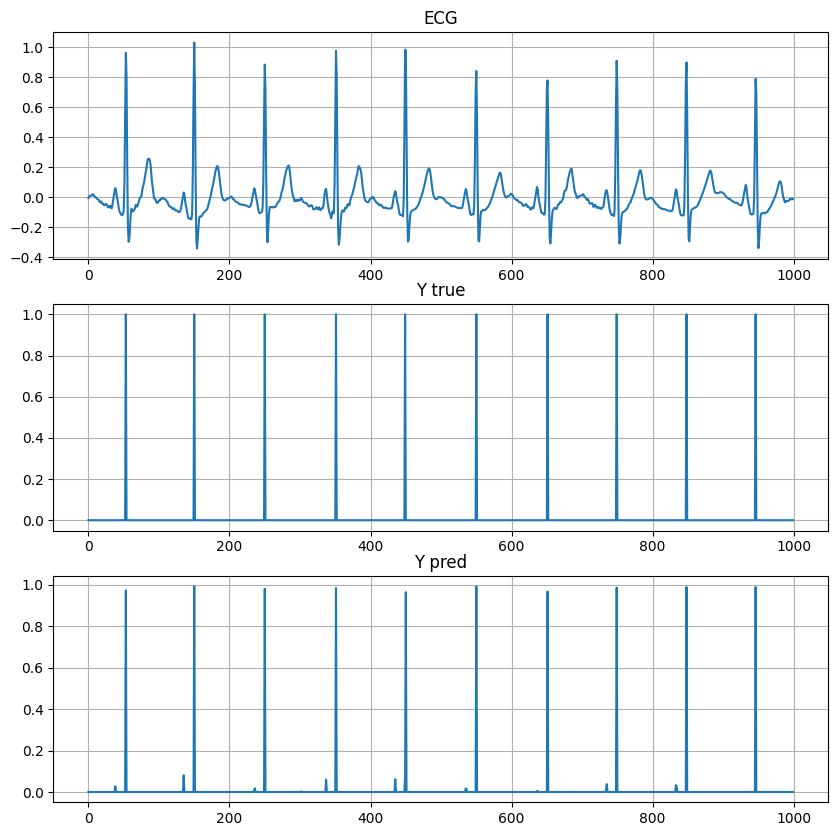

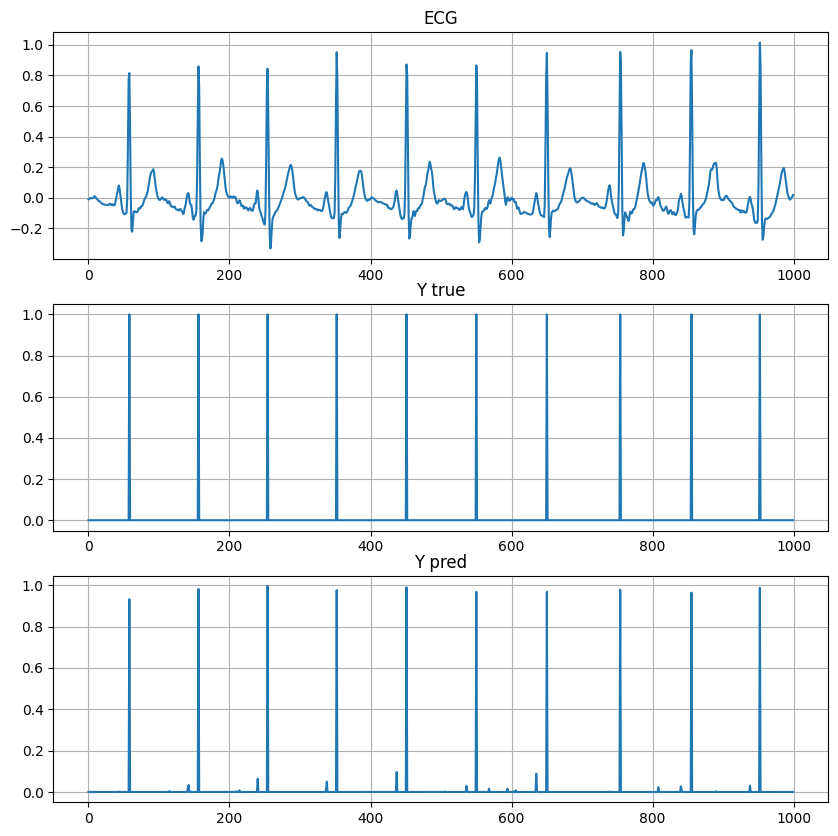

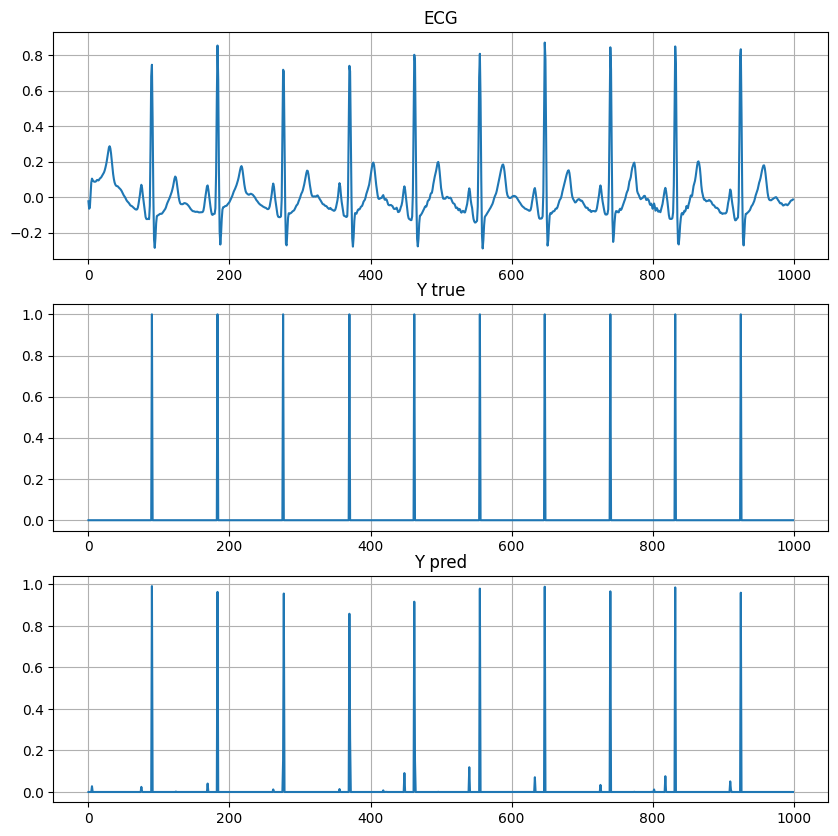

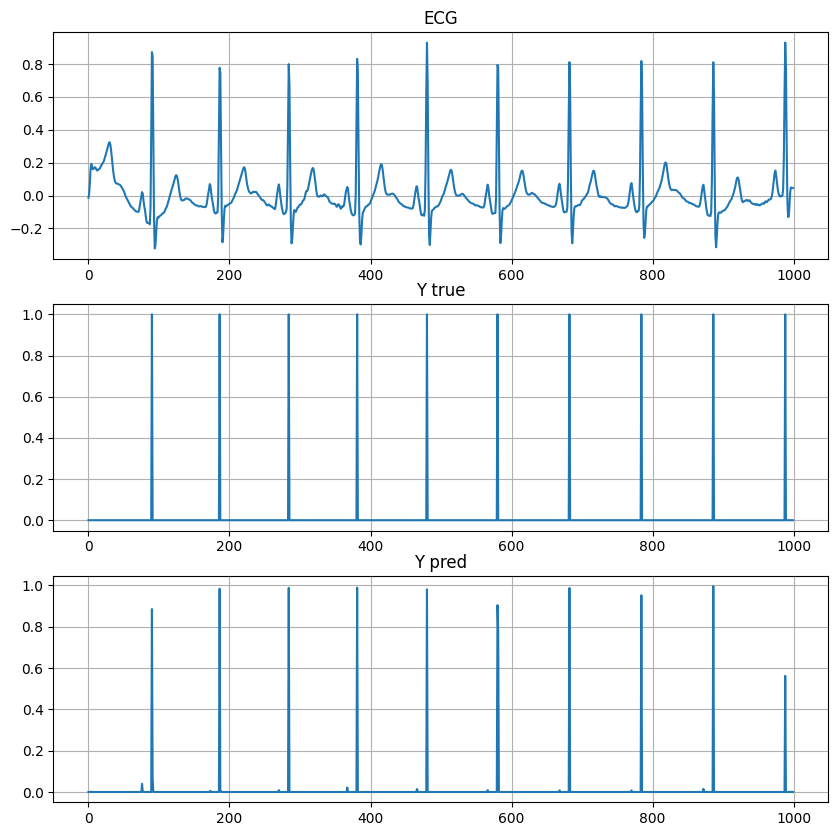

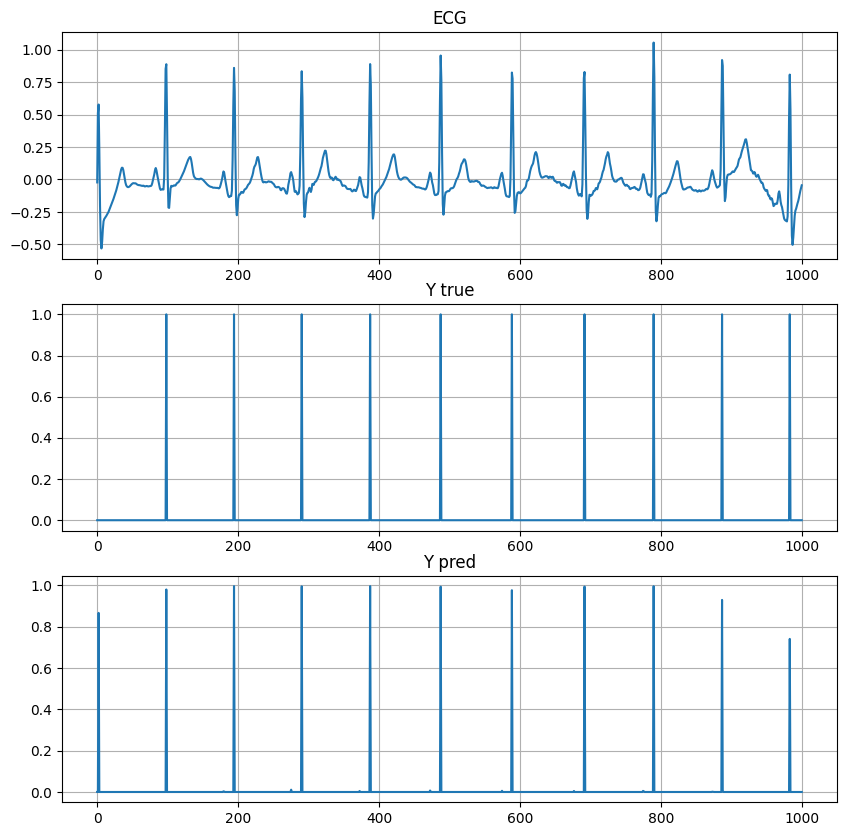

Test loss: 0.00


In [98]:
model.test_model(x_test=x_test, y_test=y_test)

In [99]:
from customLib.preprocess import *
import neurokit2 as nk
from scipy.signal import resample

In [102]:
new_ecg = np.load("E:\\ml-data\\masters-thesis\\myDataset\\Patryk\\07-05-24_16_56.npy")

x = []
y = []

for ecg in split_signal(signal=new_ecg, fs=250, window_in_seconds=10, overlap_factor=0.2):
  ecg = resample(x=ecg, num=1000)
  ecg = norm_min_max(ecg, lower=-1, upper=1)
  ecg = nk.ecg_clean(ecg, sampling_rate=100)
  _, r_peaks = nk.ecg_peaks(ecg, sampling_rate=100)
  r_peaks_indices = r_peaks["ECG_R_Peaks"]

  label = np.zeros_like(ecg)

  label[r_peaks_indices] = 1

  x.append(ecg)
  y.append(label)

x = np.array(x)
y = np.array(y)

x = torch.Tensor(np.expand_dims(x, axis=2))
y = torch.Tensor(np.expand_dims(y, axis=2))

C:\Users\patry\AppData\Local\Temp\ipykernel_9044\2813727991.py:11: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  sample = torch.tensor(self.data[idx], dtype=torch.float32)
C:\Users\patry\AppData\Local\Temp\ipykernel_9044\2813727991.py:12: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  label = torch.tensor(self.labels[idx], dtype=torch.float32)


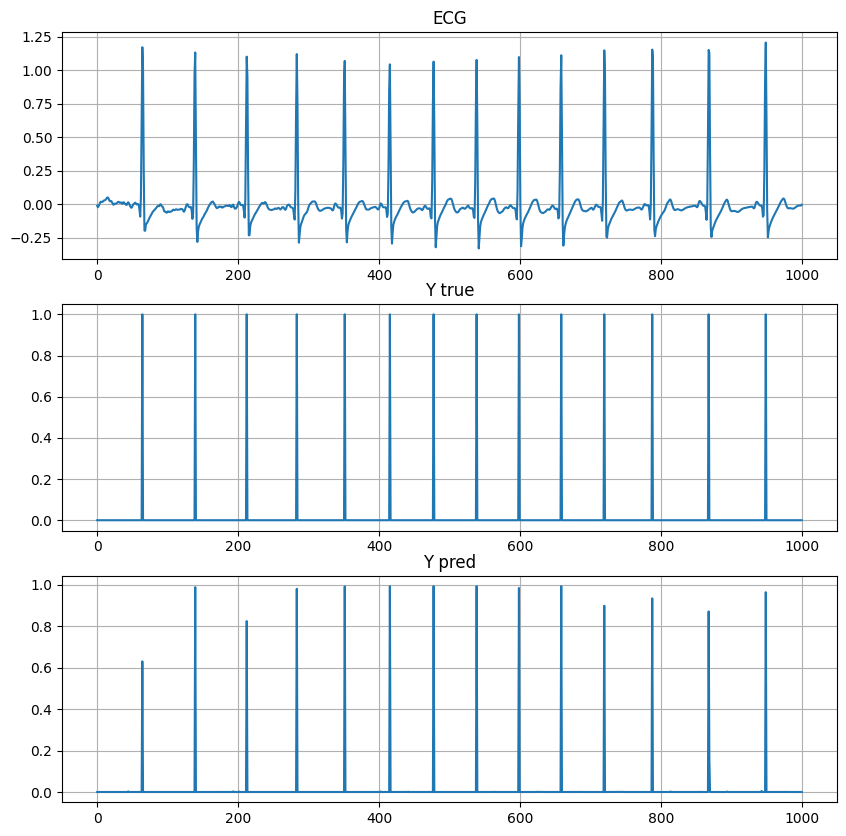

Test loss: 0.00


In [103]:
model.test_model(x, y)